In [1]:
import pandas as pd

# Loading dataset
ind_df = pd.read_csv('data/indigenous_collection_processed.csv', index_col='id')
print(f'Dataframe columns: \n{ind_df.columns}')

Dataframe columns: 
Index(['url', 'thumbnail', 'creation_date', 'modification_date',
       'numero_do_item', 'tripticos', 'categoria', 'nome_do_item',
       'nome_do_item_dic', 'colecao', 'coletor', 'doador', 'modo_de_aquisicao',
       'data_de_aquisicao', 'ano_de_aquisicao', 'data_de_confeccao', 'autoria',
       'nome_etnico', 'descricao', 'dimensoes', 'funcao', 'materia_prima',
       'tecnica_confeccao', 'descritor_tematico', 'descritor_comum',
       'numero_de_pecas', 'itens_relacionados', 'responsavel_guarda',
       'inst_detentora', 'povo', 'autoidentificacao', 'lingua',
       'estado_de_origem', 'geolocalizacao', 'pais_de_origem', 'exposicao',
       'referencias', 'disponibilidade', 'qualificacao', 'historia_adm',
       'notas_gerais', 'observacao', 'conservacao', 'image_path'],
      dtype='object')


In [2]:
import importlib
from IPython.core.magic import register_cell_magic

# Creating skip cell command
@register_cell_magic
def skip(line, cell):
    return

# Image Clustering

Clustering experiments with image feature extractors. The idea is to fine-tune some pre-trained models on our dataset and then remove the last layer of the model to cluster on the embedding space projections.

## Dataset Preparation

For fine-tuning the model on our dataset, we are going to try a few different labels and study how they affect the generated emebdding space. For now, we focus *povo* and *categoria*.

In [3]:
from PIL import Image

# Filtering out corrupted images
corrupted_images = []
for index, row in ind_df.loc[ind_df['image_path'].notna()].iterrows():
    try:
        Image.open(row['image_path'])
    except Exception as e:
        corrupted_images.append(row['image_path'])
        ind_df.loc[index, 'image_path'] = pd.NA
print(f'{len(corrupted_images)} corrupted images')

# Creating 'image_path_br' column
ind_df['image_path_br'] = ind_df['image_path'].values
ind_df.loc[ind_df['image_path_br'].notna(), 'image_path_br'] = \
    ind_df.loc[ind_df['image_path_br'].notna(), \
               'image_path'].apply(lambda path: \
                                   f"data/br_images/{path.split('/')[-1].split('.')[0]}.png")

1 corrupted images


## ViT Base Patch-16

### Pre-trained Embedding Space

In [4]:
import torch
from torchvision import transforms
from training_utils import preparing_image_labels, ImageDataset

# Getting the proper device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Building dataset for column 'povo' (though no specific column is used on off-the-shelf model)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
labels, name_to_num, num_to_name = preparing_image_labels(ind_df, 'povo')
dataset = ImageDataset(labels, transform=transform, augment=False)

In [5]:
# Projecting data onto the off-the-shelf pre-trained embedding space from ViT
from tqdm import tqdm
import numpy as np
from torch.utils.data import DataLoader
from transformers import ViTImageProcessor, ViTModel
from training_utils import get_vit_embeddings, data_projections

# Loading model
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
model.to(device)

# Getting data
dataloader = DataLoader(dataset, batch_size=512, shuffle=True, num_workers=0, pin_memory=True)

# Computing image embeddings
image_embeddings, _ = get_vit_embeddings(model, dataloader, device)
image_embeddings = np.concatenate(image_embeddings, axis=0)

# Computing data projection
vanilla_vit_trimap, vanilla_vit_tsne, vanilla_vit_umap = data_projections(image_embeddings)

Computing embeddings: 100%|████| 23/23 [03:00<00:00,  7.87s/it]
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [6]:
from training_utils import clean_mem

# Cleaning up memory
clean_mem([model, image_embeddings])

### Fine-tuning Embedding Space

In [7]:
# Creating our own ViT classifier head for fine-tuning
import torch.nn as nn

class ViTClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ViTClassifier, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_classes)

    def forward(self, x):
        outputs = self.vit(x)
        
        # Do I get the last_hidden_state of CLS token or the pooler_output?
        embeddings = outputs['last_hidden_state'][:, 0, :]
        # embeddings = outputs['pooler_output']

        logits = self.classifier(embeddings)
        return logits

#### *povo* Column

In [8]:
# Studying data distribution to filter out rare classes
from training_utils import study_class_distribution

categories, categories_keys, categories_freq, qs, masks = study_class_distribution(labels)

# Filtering classes so that we retain around 85% of data
filtered_categories = {}
filtered_categories_names = {}
for c in masks[3][0]:
    filtered_categories[categories_keys[c]] = categories[categories_keys[c]]
    filtered_categories_names[num_to_name[categories_keys[c]]] = categories[categories_keys[c]]

Quantile X Data Percentage:
Q-10: 1.00, 99.84% of data
Q-25: 4.00, 99.18% of data
Q-50: 19.00, 95.96% of data
Q-75: 65.75, 83.18% of data
Q-90: 158.20, 63.25% of data



In [9]:
# Filtering dataframe for selected categories
from training_utils import filter_image_data_distribution

threshold_multiplier = 2
minority_classes, majority_classes, labels_minority, labels_majority, \
augmented_dataset = filter_image_data_distribution(ind_df, filtered_categories_names, \
                                                   transform, threshold_multiplier, 'povo')

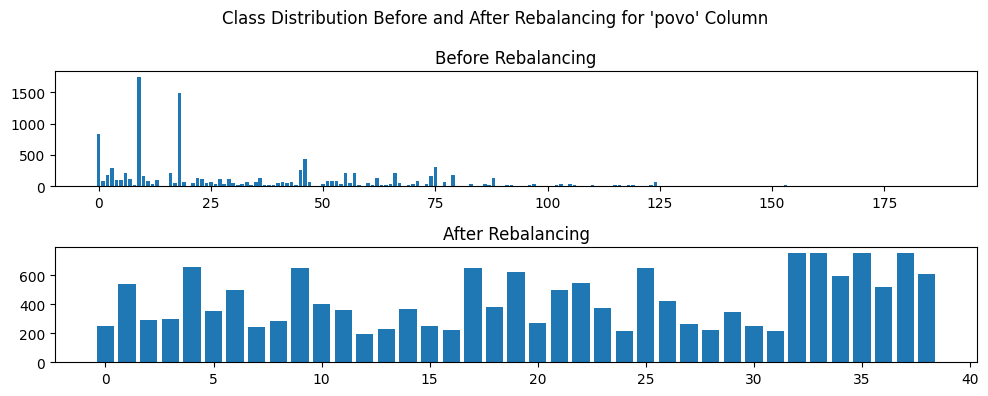

In [10]:
# Plotting old and new class distributions
from training_utils import plot_class_distributions

plot_class_distributions(categories, filtered_categories, labels_minority, labels_majority, \
                         threshold_multiplier, 'povo')

In [11]:
# Because the dataset is still unbalanced, we also create class weights for the loss function
from training_utils import compute_class_weights

class_weights = compute_class_weights(filtered_categories, labels_minority, labels_majority, \
                                      device, threshold_multiplier)

Training model:   3%|▎       | 1/30 [04:05<1:58:47, 245.77s/it]

Best model saved at epoch 1
Epoch 1, Loss: 1035.6897, Validation Accuracy: 0.3477


Training model:   7%|▌       | 2/30 [08:12<1:55:02, 246.51s/it]

Best model saved at epoch 2
Epoch 2, Loss: 770.8634, Validation Accuracy: 0.4323


Training model:  10%|▊       | 3/30 [12:19<1:50:55, 246.49s/it]

Best model saved at epoch 3
Epoch 3, Loss: 599.8006, Validation Accuracy: 0.5092


Training model:  13%|█       | 4/30 [16:22<1:46:13, 245.14s/it]

Best model saved at epoch 4
Epoch 4, Loss: 456.0876, Validation Accuracy: 0.5618


Training model:  17%|█▎      | 5/30 [20:26<1:41:55, 244.61s/it]

Best model saved at epoch 5
Epoch 5, Loss: 334.0623, Validation Accuracy: 0.6056


Training model:  20%|█▌      | 6/30 [24:26<1:37:16, 243.19s/it]

Best model saved at epoch 6
Epoch 6, Loss: 227.3082, Validation Accuracy: 0.6357


Training model:  23%|█▊      | 7/30 [28:16<1:31:34, 238.90s/it]

Best model saved at epoch 7
Epoch 7, Loss: 149.6042, Validation Accuracy: 0.6505


Training model:  27%|██▏     | 8/30 [32:05<1:26:24, 235.67s/it]

Best model saved at epoch 8
Epoch 8, Loss: 99.0797, Validation Accuracy: 0.6529


Training model:  30%|██▍     | 9/30 [35:53<1:21:39, 233.31s/it]

Epoch 9, Loss: 74.3908, Validation Accuracy: 0.6481


Training model:  33%|██▎    | 10/30 [39:47<1:17:51, 233.58s/it]

Best model saved at epoch 10
Epoch 10, Loss: 60.5553, Validation Accuracy: 0.6606


Training model:  37%|██▌    | 11/30 [43:46<1:14:31, 235.36s/it]

Epoch 11, Loss: 42.1373, Validation Accuracy: 0.6576


Training model:  40%|██▊    | 12/30 [47:46<1:10:57, 236.54s/it]

Epoch 12, Loss: 31.9929, Validation Accuracy: 0.6499


Training model:  43%|███    | 13/30 [51:43<1:07:05, 236.82s/it]

Epoch 13, Loss: 30.5088, Validation Accuracy: 0.6570


Training model:  47%|███▎   | 14/30 [55:45<1:03:31, 238.21s/it]

Best model saved at epoch 14
Epoch 14, Loss: 16.0892, Validation Accuracy: 0.6688


Training model:  50%|████▌    | 15/30 [59:47<59:52, 239.47s/it]

Best model saved at epoch 15
Epoch 15, Loss: 10.3293, Validation Accuracy: 0.6706


Training model:  53%|███▋   | 16/30 [1:03:49<56:05, 240.36s/it]

Epoch 16, Loss: 7.5967, Validation Accuracy: 0.6700


Training model:  57%|███▉   | 17/30 [1:07:47<51:54, 239.60s/it]

Epoch 17, Loss: 5.9722, Validation Accuracy: 0.6700


Training model:  60%|████▏  | 18/30 [1:11:43<47:40, 238.37s/it]

Epoch 18, Loss: 4.8871, Validation Accuracy: 0.6688


Training model:  63%|████▍  | 19/30 [1:15:40<43:39, 238.17s/it]

Epoch 19, Loss: 4.0923, Validation Accuracy: 0.6706


Training model:  67%|████▋  | 20/30 [1:19:37<39:35, 237.59s/it]

Best model saved at epoch 20
Epoch 20, Loss: 3.3501, Validation Accuracy: 0.6718


Training model:  70%|████▉  | 21/30 [1:23:30<35:25, 236.21s/it]

Best model saved at epoch 21
Epoch 21, Loss: 2.7755, Validation Accuracy: 0.6765


Training model:  73%|█████▏ | 22/30 [1:27:22<31:20, 235.12s/it]

Epoch 22, Loss: 2.3444, Validation Accuracy: 0.6742


Training model:  77%|█████▎ | 23/30 [1:31:15<27:20, 234.29s/it]

Epoch 23, Loss: 1.9682, Validation Accuracy: 0.6742


Training model:  80%|█████▌ | 24/30 [1:35:08<23:23, 233.89s/it]

Best model saved at epoch 24
Epoch 24, Loss: 1.7017, Validation Accuracy: 0.6783


Training model:  83%|█████▊ | 25/30 [1:39:00<19:26, 233.37s/it]

Epoch 25, Loss: 1.4816, Validation Accuracy: 0.6653


Training model:  87%|██████ | 26/30 [1:42:52<15:31, 232.93s/it]

Epoch 26, Loss: 1.2482, Validation Accuracy: 0.6730


Training model:  90%|██████▎| 27/30 [1:46:47<11:41, 233.81s/it]

Epoch 27, Loss: 1.0887, Validation Accuracy: 0.6765


Training model:  93%|██████▌| 28/30 [1:50:45<07:50, 235.03s/it]

Epoch 28, Loss: 1.0062, Validation Accuracy: 0.6777


Training model:  97%|██████▊| 29/30 [1:54:44<03:56, 236.00s/it]

Epoch 29, Loss: 0.9176, Validation Accuracy: 0.6700


Training model: 100%|███████| 30/30 [1:58:42<00:00, 237.43s/it]


Epoch 30, Loss: 0.8814, Validation Accuracy: 0.6730


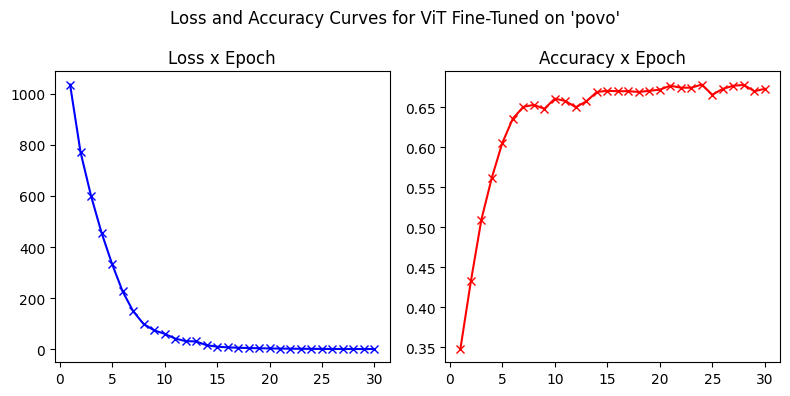

Per class precision: [0.720703125, 0.39990234375, 0.333251953125, 0.53857421875, 0.63623046875, 0.47607421875, 0.94140625, 0.466552734375, 0.85693359375, 0.85693359375, 0.53125, 0.9091796875, 0.0, 0.2142333984375, 0.0, 0.0, 0.7578125, 0.428466796875, 0.80908203125, 0.46142578125, 0.0, 0.60009765625, 0.68017578125, 0.9443359375, 0.7998046875, 0.10528564453125, 0.7998046875, 0.6875, 0.66650390625, 0.7001953125, 0.5, 0.0, 0.5, 0.5712890625, 1.0, 0.75, 0.83349609375, 0.0, 0.0, 0.0, 0.4443359375, 0.60009765625, 0.1666259765625, 0.83349609375, 1.0, 0.71044921875, 0.7392578125, 1.0, 0.0, 0.0, 0.375, 0.888671875, 0.39990234375, 0.5, 1.0, 0.7744140625, 0.39990234375, 0.56103515625, 0.5, 0.0, 0.5, 0.5, 0.162841796875, 0.0, 0.0, 0.333251953125, 0.54150390625, 0.75, 0.0, 0.0, 0.0, 0.625, 0.0, 0.5, 0.70947265625, 0.673828125, 0.0, 0.7998046875, 0.0, 0.54541015625, 0.0, 1.0, 0.0, 0.85693359375, 0.0, 0.5, 0.333251953125, 1.0, 0.5556640625, 0.0, 0.0, 0.0, 0.66650390625, 0.0, 0.0, 1.0, 1.0, 0.333251953

/home/lui/Documents/uva/thesis/indigenous_project/tainacan_collection/training_utils.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('data/mode

Test accuracy: 0.686170220375061

Test per class precisions: [0.8734177350997925, 0.23076923191547394, 0.2666666805744171, 0.5945945978164673, 0.1666666716337204, 0.4285714328289032, 0.9655172228813171, 1.0, 1.0, 0.9182389974594116, 0.5263158082962036, 0.5714285969734192, 1.0, 0.2142857164144516, 0.0, 0.0, 0.8421052694320679, 0.6666666865348816, 0.7071823477745056, 0.3333333432674408, 0.0, 1.0, 0.875, 0.800000011920929, 0.75, 0.1764705926179886, 1.0, 0.47058823704719543, 0.0, 0.75, 1.0, 0.0, 0.0, 0.5, 0.0, 0.75, 0.7777777910232544, 0.0, 1.0, 0.0, 0.75, 0.75, 0.25, 0.5, 0.0, 0.7692307829856873, 0.9024389982223511, 0.8999999761581421, 0.0, 0.0, 1.0, 0.800000011920929, 0.5, 0.2857142984867096, 0.0, 0.7142857313156128, 1.0, 0.48571428656578064, 0.0, 0.0, 0.6666666865348816, 0.0, 0.3333333432674408, 1.0, 0.0, 0.75, 0.6111111044883728, 0.5714285969734192, 0.0, 0.0, 0.75, 0.375, 0.0, 0.3333333432674408, 0.5625, 0.6571428775787354, 0.0, 1.0, 0.0, 0.380952388048172, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0

In [12]:
# import training_utils
# importlib.reload(training_utils)
from training_utils import execute_train_test
import torch.nn as nn
import torch.optim as optim

# Setting-up training, executing training and then running tests
batch_size = 32
epochs = 30
num_classes = ind_df['povo'].nunique()
model = ViTClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-5)
model_name = 'vit_povo'
column_name = 'povo'

execute_train_test(dataset, device, batch_size, epochs, num_classes, model, criterion, opt, \
                   model_name, column_name)

In [13]:
# Cleaning up memory
clean_mem([model, image_embeddings])

Training model:   3%|▎       | 1/30 [07:15<3:30:34, 435.67s/it]

Best model saved at epoch 1
Epoch 1, Loss: 1162.4972, Validation Accuracy: 0.5573


Training model:   7%|▌       | 2/30 [14:31<3:23:23, 435.86s/it]

Best model saved at epoch 2
Epoch 2, Loss: 622.3442, Validation Accuracy: 0.7973


Training model:  10%|▊       | 3/30 [21:47<3:16:08, 435.86s/it]

Best model saved at epoch 3
Epoch 3, Loss: 221.4282, Validation Accuracy: 0.9020


Training model:  13%|█       | 4/30 [28:55<3:07:34, 432.85s/it]

Best model saved at epoch 4
Epoch 4, Loss: 69.7850, Validation Accuracy: 0.9484


Training model:  17%|█▎      | 5/30 [36:05<2:59:53, 431.76s/it]

Epoch 5, Loss: 34.2593, Validation Accuracy: 0.9421


Training model:  20%|█▌      | 6/30 [43:09<2:51:37, 429.07s/it]

Best model saved at epoch 6
Epoch 6, Loss: 25.1524, Validation Accuracy: 0.9663


Training model:  23%|█▊      | 7/30 [50:19<2:44:35, 429.39s/it]

Epoch 7, Loss: 13.1737, Validation Accuracy: 0.9599


Training model:  27%|██▏     | 8/30 [57:27<2:37:18, 429.03s/it]

Epoch 8, Loss: 15.3804, Validation Accuracy: 0.9207


Training model:  30%|█▊    | 9/30 [1:04:24<2:28:51, 425.31s/it]

Epoch 9, Loss: 23.4324, Validation Accuracy: 0.9421


Training model:  30%|█▊    | 9/30 [1:11:12<2:46:09, 474.75s/it]


Early-stopping training!


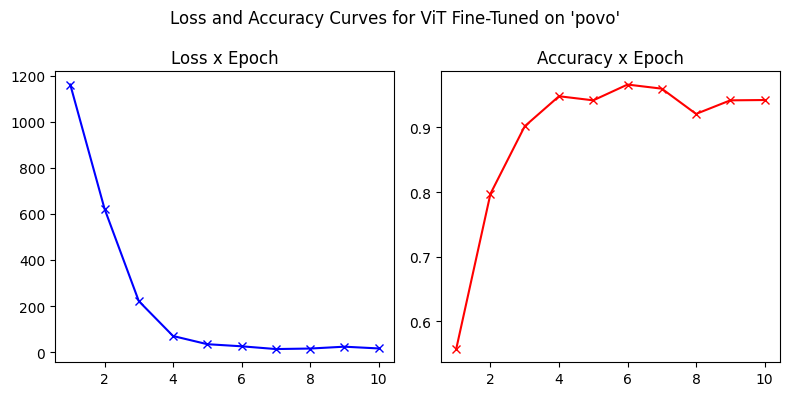

Per class precision: [0.94580078125, 0.94580078125, 0.9091796875, 0.95751953125, 1.0, 0.810546875, 0.91455078125, 0.8271484375, 0.94580078125, 0.96240234375, 0.953125, 0.9638671875, 0.94140625, 0.96142578125, 0.98193359375, 0.8974609375, 0.83349609375, 0.9609375, 0.96533203125, 0.96826171875, 0.888671875, 0.958984375, 1.0, 0.95849609375, 1.0, 1.0, 0.94140625, 0.9033203125, 1.0, 0.7607421875, 0.97412109375, 1.0, 1.0, 0.92236328125, 0.88671875, 0.9912109375, 0.91259765625, 0.93115234375, 0.96875]

Per class recall: [0.97216796875, 0.8642578125, 0.96142578125, 0.95751953125, 1.0, 0.90380859375, 0.98681640625, 1.0, 0.94580078125, 1.0, 0.96826171875, 0.9638671875, 0.94140625, 0.96142578125, 0.96484375, 0.94580078125, 0.9091796875, 0.97998046875, 0.91796875, 1.0, 1.0, 0.9208984375, 0.755859375, 0.8681640625, 1.0, 0.990234375, 1.0, 0.96533203125, 1.0, 0.96435546875, 1.0, 1.0, 0.9228515625, 0.87939453125, 0.98828125, 0.94873046875, 0.87939453125, 0.84814453125, 0.939453125]

Test accuracy: 0.9

Computing embeddings: 100%|███████| 23/23 [02:44<00:00,  7.14s/it]
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [14]:
from training_utils import compute_classifier_embeddings

# Retraining model with augmented dataset to see the difference in the results
batch_size = 32
epochs = 30
num_classes = len(filtered_categories)
model = ViTClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
opt = optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-5)
model_name = 'balanced_vit_povo'
column_name = 'povo'

execute_train_test(augmented_dataset, device, batch_size, epochs, num_classes, model, \
                   criterion, opt, model_name, column_name)

povo_vit_trimap, povo_vit_tsne, \
povo_vit_umap, image_indices = compute_classifier_embeddings(dataloader, model, device)

In [15]:
# Cleaning up memory
clean_mem([model, image_embeddings])

#### *categoria* Column

In [16]:
# Now rebalancing the 'categoria' column
labels, name_to_num, num_to_name = preparing_image_labels(ind_df, 'categoria')
dataset = ImageDataset(labels, transform=transform)
dataloader = DataLoader(dataset, batch_size=512, shuffle=True, num_workers=0, pin_memory=True)

categories, categories_keys, categories_freq, qs, masks = study_class_distribution(labels)

# Filtering out 'etnobotânica' and 'armas'
filter_out = [name_to_num['armas'], name_to_num['etnobotânica']]
filtered_categories = {}
filtered_categories_names = {}
for c in set(name_to_num.values()) - set(filter_out):
    filtered_categories[categories_keys[c]] = categories[categories_keys[c]]
    filtered_categories_names[num_to_name[categories_keys[c]]] = categories[categories_keys[c]]

Quantile X Data Percentage:
Q-10: 216.60, 99.71% of data
Q-25: 507.50, 93.33% of data
Q-50: 1060.50, 79.68% of data
Q-75: 1344.50, 58.09% of data
Q-90: 2270.70, 26.50% of data



In [17]:
# Filtering dataframe for selected categories
threshold_multiplier = 1.5
minority_classes, majority_classes, labels_minority, labels_majority, \
augmented_dataset = filter_image_data_distribution(ind_df, filtered_categories_names, \
                                                   transform, threshold_multiplier, \
                                                   'categoria')

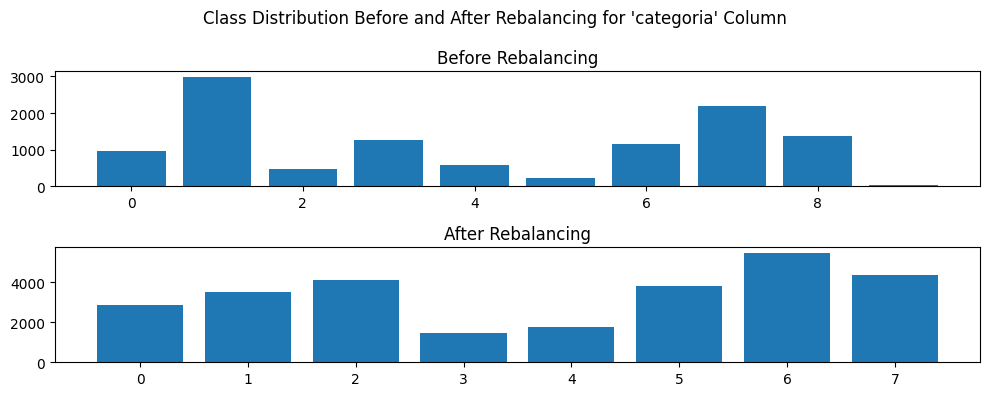

In [18]:
# Plotting old and new class distributions
from training_utils import plot_class_distributions

plot_class_distributions(categories, filtered_categories, labels_minority, labels_majority, \
                         threshold_multiplier, 'categoria')

In [19]:
# Because the dataset is still unbalanced, we also create class weights for the loss function
from training_utils import compute_class_weights

class_weights = compute_class_weights(filtered_categories, labels_minority, labels_majority, \
                                      device, threshold_multiplier)

In [ ]:
# Setting-up training, executing training and then running tests
batch_size = 32
epochs = 30
num_classes = ind_df['categoria'].nunique()
model = ViTClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=2e-5, weight_decay=1e-5)
model_name = 'vit_categoria'
column_name = 'categoria'

execute_train_test(dataset, device, batch_size, epochs, num_classes, model, criterion, opt, \
                   model_name, column_name)

Training model:   3%|▎          | 1/30 [03:51<1:51:40, 231.06s/it]

Best model saved at epoch 1
Epoch 1, Loss: 381.2599, Validation Accuracy: 0.7221


In [ ]:
# Cleaning up memory
clean_mem([model, image_embeddings])

In [ ]:
# Retraining model with augmented dataset to see the difference in the results
batch_size = 32
epochs = 30
num_classes = len(filtered_categories)
model = ViTClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=2e-5, weight_decay=1e-5)
model_name = 'balanced_vit_categoria'
column_name = 'categoria'

execute_train_test(augmented_dataset, device, batch_size, epochs, num_classes, model, \
                   criterion, opt, model_name, column_name)

categoria_vit_trimap, categoria_vit_tsne, \
categoria_vit_umap, image_indices = compute_classifier_embeddings(dataloader, model, device)

In [ ]:
# Cleaning up memory
clean_mem([model, image_embeddings])

### Visualizing and Comparing Projections

In [ ]:
from training_utils import normalize

# Normalizing data for later plot on tool
norm_factor = 12
vanilla_vit_trimap = normalize(vanilla_vit_trimap, norm_factor)
vanilla_vit_tsne = normalize(vanilla_vit_tsne, norm_factor)
vanilla_vit_umap = normalize(vanilla_vit_umap, norm_factor)

povo_vit_trimap = normalize(povo_vit_trimap, norm_factor)
povo_vit_tsne = normalize(povo_vit_tsne, norm_factor)
povo_vit_umap = normalize(povo_vit_umap, norm_factor)

categoria_vit_trimap = normalize(categoria_vit_trimap, norm_factor)
categoria_vit_tsne = normalize(categoria_vit_tsne, norm_factor)
categoria_vit_umap = normalize(categoria_vit_umap, norm_factor)

In [ ]:
# Visualizing resulting projections
plt.figure(figsize=(12,8))
plt.suptitle('Comparing Projections of ViT Models')

# Plotting vanilla ViT projections
for i, (vanilla_vit, proj_name) in enumerate(zip([vanilla_vit_trimap, \
                                                  vanilla_vit_tsne, vanilla_vit_umap], \
                                                 ['TriMap', 't-SNE', 'UMAP'])):
    plt.subplot(3, 3, i+1)
    plt.scatter(vanilla_vit[:, 0], vanilla_vit[:, 1], c='b')
    plt.title("Vanilla ViT with " + proj_name)
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks([])
    plt.yticks([])

# Plotting ViT fine-tuned on 'povo' projections
for i, (povo_vit, proj_name) in enumerate(zip([povo_vit_trimap, \
                                               povo_vit_tsne, povo_vit_umap], \
                                              ['TriMap', 't-SNE', 'UMAP'])):
    plt.subplot(3, 3, i+4)
    plt.scatter(povo_vit[:, 0], povo_vit[:, 1], c='r')
    plt.title("ViT Fine-Tuned on 'povo' with " + proj_name)
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks([])
    plt.yticks([])

# Plotting ViT fine-tuned on 'categoria' projections
for i, (categoria_vit, proj_name) in enumerate(zip([categoria_vit_trimap, \
                                                    categoria_vit_tsne, categoria_vit_umap], \
                                                   ['TriMap', 't-SNE', 'UMAP'])):
    plt.subplot(3, 3, i+7)
    plt.scatter(categoria_vit[:, 0], categoria_vit[:, 1], c='g')
    plt.title("ViT Fine-Tuned on 'categoria' with " + proj_name)
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

### Visualizing Clusters

In [ ]:
# Filtering dataframe to get only the part that contains images
filtered_df = ind_df.loc[ind_df['image_path'].notna()]

# Building colormap for cluster visualization
column = 'categoria' # 'povo', 'categoria', 'ano_de_aquisicao'
unique_values = filtered_df[column].unique()
colors = plt.cm.gnuplot(np.linspace(0, 1, len(unique_values)))
color_dict = {cluster: colors[i] for i, cluster in enumerate(unique_values)}

# Reordering projections to match the original dataframe order
categoria_vit_umap = categoria_vit_umap[np.argsort(image_indices)]

# Plotting projections with clusters
plt.figure(figsize=(10,4))

for cluster in unique_values:
    mask = filtered_df.index[filtered_df[column] == cluster].tolist()
    sequential_indices = np.array([filtered_df.index.get_loc(idx) for idx in mask])
    plt.scatter(categoria_vit_umap[sequential_indices, 0], \
                categoria_vit_umap[sequential_indices, 1], 
                color=color_dict[cluster], label=f"{cluster.title()}", alpha=0.7)

plt.title(f"Visualizing Clusters for Categoria on UMAP Projection")
plt.xlabel("")
plt.ylabel("")
plt.xticks([])
plt.yticks([])
plt.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc="upper left", \
           fontsize=8, frameon=True)

plt.tight_layout()
plt.show()

In [38]:
categoria_vit_umap = categoria_vit_umap[np.argsort(image_indices)]

array([2591, 4851, 9029, ..., 4677, 6248,  431])

In [37]:
np.unique(list(labels.values()))
print(num_to_name)
print(name_to_num)

{0: 'utensílios e implementos de materiais ecléticos', 1: 'adornos de materiais ecléticos, indumentária e toucador', 2: 'instrumentos musicais e de sinalização', 3: 'cordões e tecidos', 4: 'adornos plumários', 5: 'armas', 6: 'trançados', 7: 'cerâmica', 8: 'objetos rituais, mágicos e lúdicos', 9: 'etnobotânica'}
{'utensílios e implementos de materiais ecléticos': 0, 'adornos de materiais ecléticos, indumentária e toucador': 1, 'instrumentos musicais e de sinalização': 2, 'cordões e tecidos': 3, 'adornos plumários': 4, 'armas': 5, 'trançados': 6, 'cerâmica': 7, 'objetos rituais, mágicos e lúdicos': 8, 'etnobotânica': 9}


In [40]:
# Saving outputs for visualization tool
# print(labels)
mask1 = filtered_df.index[filtered_df[column] == unique_values[5]].tolist()
mask2 = filtered_df.index[filtered_df[column] == unique_values[8]].tolist()

sequence1 = np.array([filtered_df.index.get_loc(idx) for idx in mask1])
sequence2 = np.array([filtered_df.index.get_loc(idx) for idx in mask2])

print(len(set(sequence1).union(set(sequence2))) == len(sequence1)+len(sequence2))

True
